[1] "China"


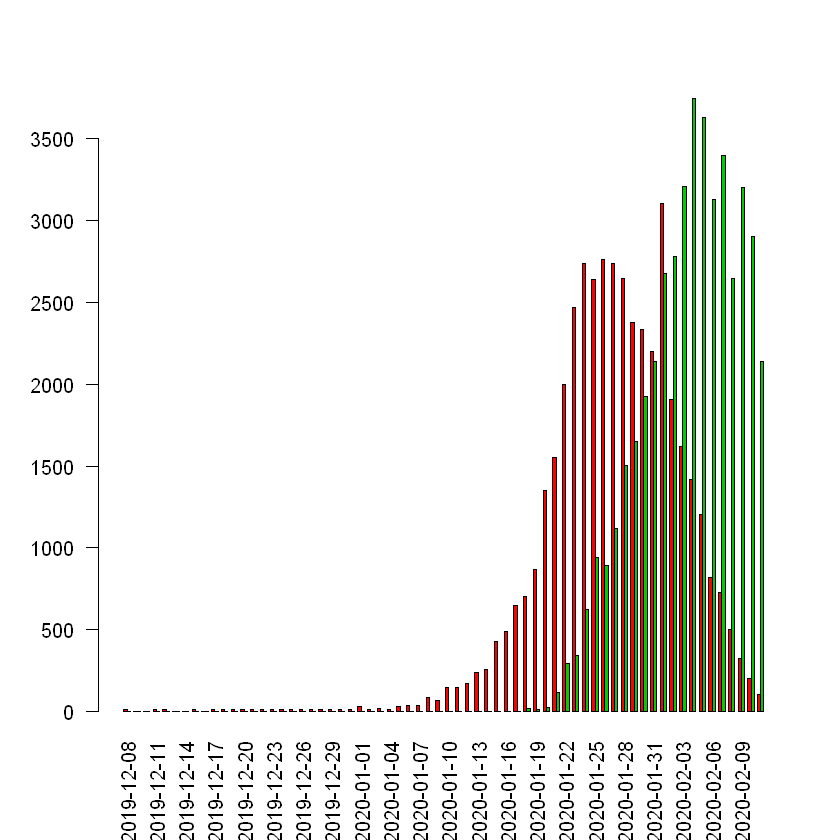

[1] "Italy"


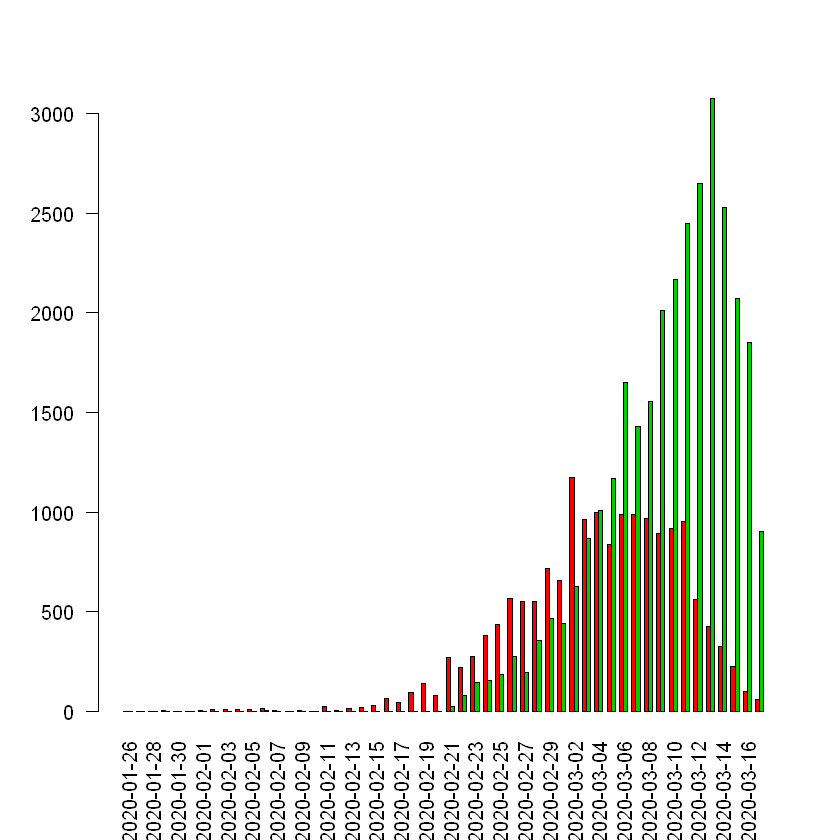

[1] "Germany"


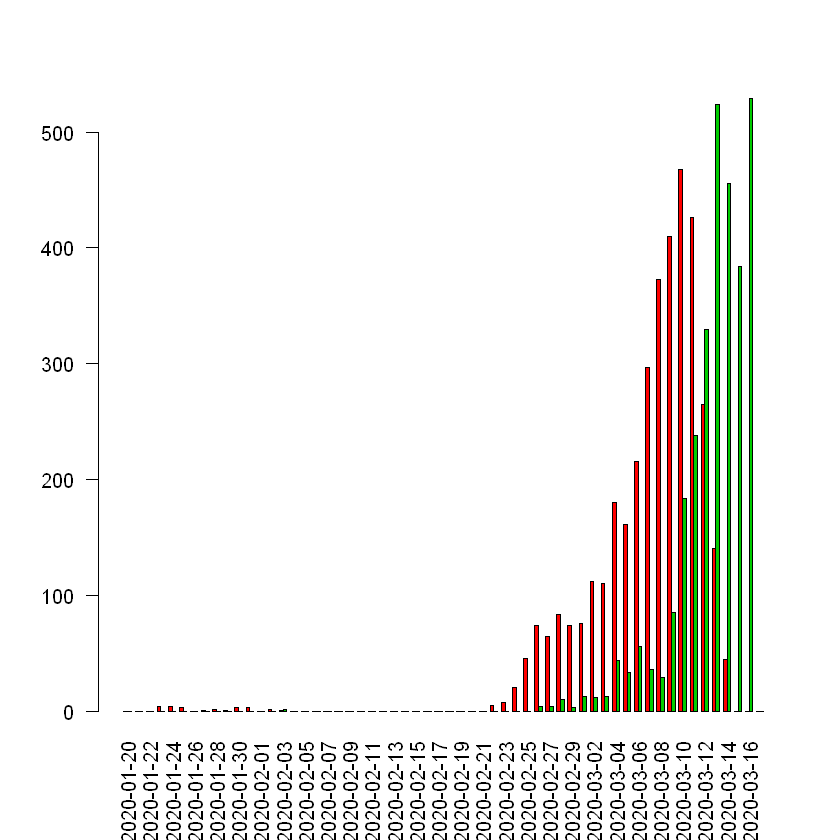

In [1]:
library(EpiNow)
# load data
countrynames=c("China","Italy","Germany")
names(countrynames)=countrynames
dataset=lapply(countrynames,function(name){read.csv(paste0(name,"_onset_diagnosis.csv"),colClasses=c("Date","double","double"))})
names(dataset)=countrynames
dataset=lapply(dataset,function(x){data.frame(date=x[,1],round(pmax(as.matrix(x[,-1]),0)))})
dataset$Germany[,"diagnosis"]=pmax(dataset$Germany[,"diagnosis"]-dataset$Germany[,"onset"],0)
for(x in names(dataset)){barplot(names.arg=dataset[[x]][,1],t(as.matrix(dataset[[x]][,-1])),beside=T,las=2,col=2:3);print(x)}

In [2]:
# get data to supply with nowcast_pipeline
countryvars=lapply(countrynames,function(country){
    linelist=NCoVUtils::get_international_linelist(country)
    total_cases <- NCoVUtils::get_who_cases(country = country, daily = TRUE)
    cases <- EpiNow::get_local_import_case_counts(total_cases, linelist, cases_from = "2020-01-18")
    #cases <- data.table::as.data.table(cbind(dataset[[country]][,c("date","diagnosis")],import_status="local"))
    #cases <- dplyr::rename(cases,cases=diagnosis)
    target_date <- as.character(max(cases$date))
    list(linelist=linelist,cases=cases,target_date=target_date,earliest_allowed_onset = "2020-01-18")
})


Warning message:
" 6 failed to parse."Warning message in `_f`(input = input, file = file, text = text, cmd = cmd, sep = sep, :
"'autostart' is now deprecated and ignored. Consider skip='string' or skip=n"Downloading linelist data
Warning message in `_f`(input = input, file = file, text = text, cmd = cmd, sep = sep, :
"'autostart' is now deprecated and ignored. Consider skip='string' or skip=n"Downloading linelist data


In [3]:
# impute datasets (100 samples) with nowcast_pipeline
nsamples=100
imp_dataset=lapply(countryvars,function(vars){
    linelist=vars$linelist
    cases=vars$cases
    target_date=vars$target_date
    earliest_allowed_onset=vars$earliest_allowed_onset
    formatted_linelist <- linelist %>%
    dplyr::rename(date_onset_symptoms = date_onset,
                  date_confirmation = date_confirm,
                  delay_confirmation = report_delay)
    ##Reformat cases
    cases <- cases %>% dplyr::rename(confirm = cases)
    nowcast <- EpiNow::nowcast_pipeline(reported_cases = cases,
                                                 linelist = formatted_linelist,
                                                 date_to_cast = target_date,
                                                 earliest_allowed_onset = earliest_allowed_onset,
                                                 samples=nsamples)
    nowcast
})

Fitting reporting delay between the 2020-01-18 and the 2020-04-05
Gamma selected as the best fit for the delay distribution
Nowcasting using fitted delay distributions
Fitting reporting delay between the 2020-01-31 and the 2020-04-05
Warning message:
"There were 11 divergent transitions after warmup. Increasing adapt_delta above 0.999 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Exponential selected as the best fit for the delay distribution
Nowcasting using fitted delay distributions
Fitting reporting delay between the 2020-01-27 and the 2020-04-05
Exponential selected as the best fit for the delay distribution
Nowcasting using fitted delay distributions


In [4]:
# combine nowcast data with validation data
imp_onsetdata=lapply(imp_dataset,function(x){
    dtx=data.table::as.data.table(x)
    datelength=length(unique(dtx$date))
    datasamples=lapply(1:nsamples,function(sampl){dtx[import_status=="local"][sample==sampl,list(date,cases)]})
    bindsamples=purrr::reduce(datasamples,function(x,y){merge(x,dplyr::rename(y,!!(paste("cases",ncol(x))):=cases),by="date",all=T)})
    data.frame(date=bindsamples[,date],cases=rowMeans(bindsamples[,-1],))
})
#imp_onsetdata=lapply(imp_dataset,function(x){x=x[x$sample==1,];data.frame(date=x$date,cases=x$cases)})
mergeddataset=lapply(countrynames,function(country){merge(dataset[[country]],imp_onsetdata[[country]],by="date",all=T)})

[1] "China"


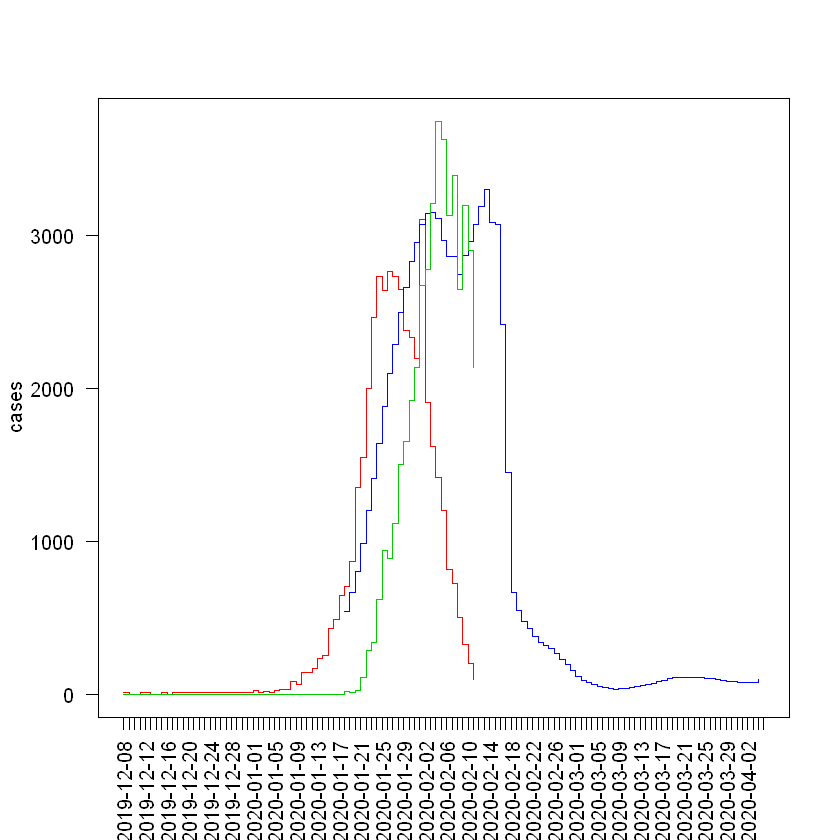

[1] "Italy"


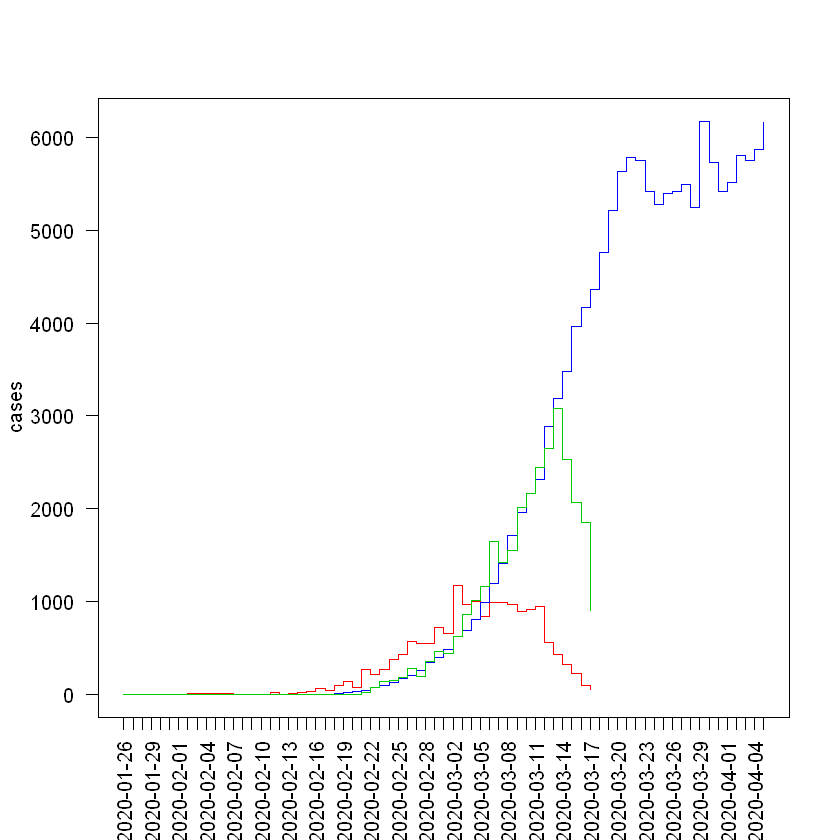

[1] "Germany"


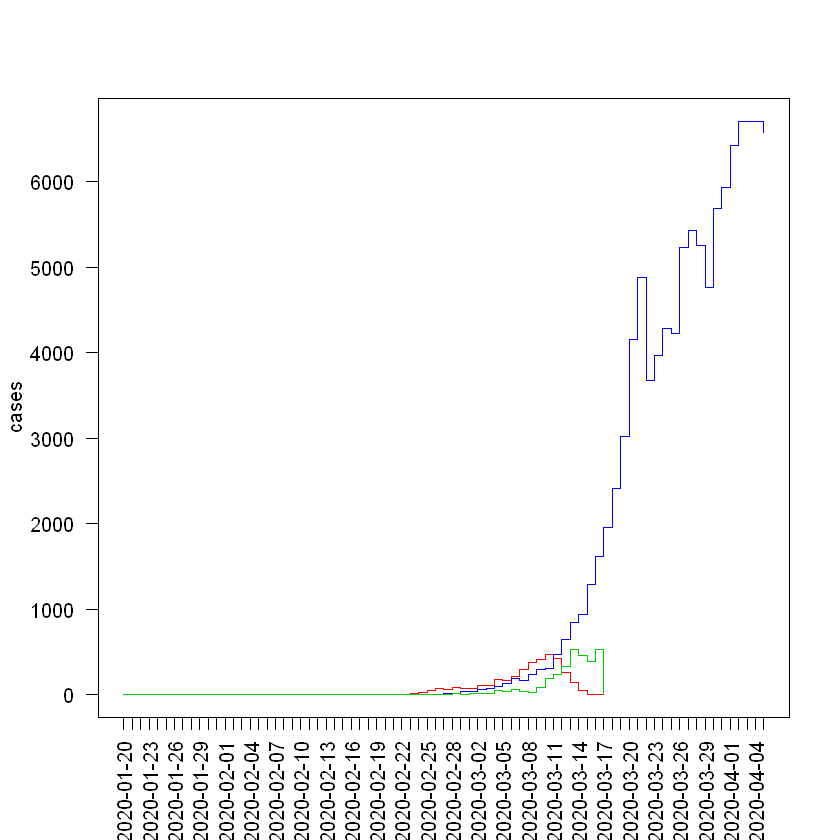

In [5]:
# plot
for(x in names(mergeddataset)){
    dates=mergeddataset[[x]][,"date"]
    matplot(x=dates,y=mergeddataset[[x]][,c("onset","cases","diagnosis")],type="s",lty=1,las=2,col=c(2,4,3),xlab="",ylab="cases",xaxt="n")
    axis(1,dates,dates,las=2)
    print(x)
}

In [6]:
validation_pipeline=function(dataset_,countrynames=list("China"),targetdate=NULL,nsamples=100){
    names(countrynames)=unlist(countrynames)
    # get data to supply with nowcast_pipeline
    countryvars=lapply(countrynames,function(country){
        linelist=NCoVUtils::get_international_linelist(country)
        total_cases <- NCoVUtils::get_who_cases(country = country, daily = TRUE)
        cases <- EpiNow::get_local_import_case_counts(total_cases, linelist, cases_from = "2020-01-18")
        #cases <- data.table::as.data.table(cbind(dataset[[country]][,c("date","diagnosis")],import_status="local"))
        #cases <- dplyr::rename(cases,cases=diagnosis)
        target_date <- ifelse(is.null(targetdate),as.character(max(cases$date)),targetdate)
        list(linelist=linelist,cases=cases,target_date=target_date,earliest_allowed_onset = as.character(min(cases$date)))
    })
    # impute datasets (100 samples) with nowcast_pipeline
    imp_dataset=lapply(countryvars,function(vars){
        linelist=vars$linelist
        cases=vars$cases
        target_date=vars$target_date
        earliest_allowed_onset=vars$earliest_allowed_onset
        formatted_linelist <- linelist %>%
        dplyr::rename(date_onset_symptoms = date_onset,
                  date_confirmation = date_confirm,
                  delay_confirmation = report_delay)
        ##Reformat cases
        cases <- cases %>% dplyr::rename(confirm = cases)
        nowcast <- EpiNow::nowcast_pipeline(reported_cases = cases,
                                                 linelist = formatted_linelist,
                                                 date_to_cast = target_date,
                                                 earliest_allowed_onset = earliest_allowed_onset,
                                                 samples=nsamples)
        nowcast
    })
    # combine nowcast data with validation data
    imp_onsetdata=lapply(imp_dataset,function(x){
        dtx=data.table::as.data.table(x)
        datelength=length(unique(dtx$date))
        datasamples=lapply(1:nsamples,function(sampl){dtx[import_status=="local"][sample==sampl,list(date,cases)]})
        bindsamples=purrr::reduce(datasamples,function(x,y){merge(x,dplyr::rename(y,!!(paste("cases",ncol(x))):=cases),by="date",all=T)})
        data.frame(date=bindsamples[,date],cases=rowMeans(bindsamples[,-1],))
    })
    mergeddataset=lapply(countrynames,function(country){merge(dataset_[[country]],imp_onsetdata[[country]],by="date",all=T)})
    mergeddataset
}

In [7]:
enddates=as.Date("2020-1-27")+0:2*7
chinanowcast=lapply(enddates,function(enddate){validation_pipeline(dataset,list("China"),targetdate=enddate)})

Warning message:
" 6 failed to parse."Fitting reporting delay between the 2020-01-18 and the 18288
Gamma selected as the best fit for the delay distribution
Nowcasting using fitted delay distributions
Warning message:
" 6 failed to parse."Fitting reporting delay between the 2020-01-18 and the 18295
Gamma selected as the best fit for the delay distribution
Nowcasting using fitted delay distributions
Warning message:
" 6 failed to parse."Fitting reporting delay between the 2020-01-18 and the 18302
Gamma selected as the best fit for the delay distribution
Nowcasting using fitted delay distributions


[1] 1


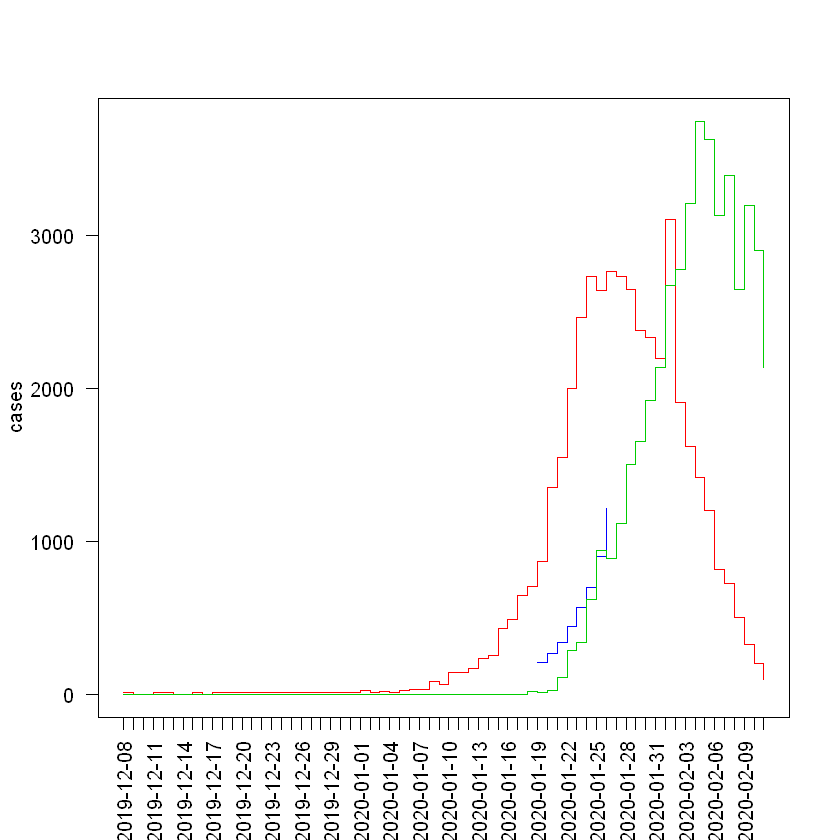

[1] 2


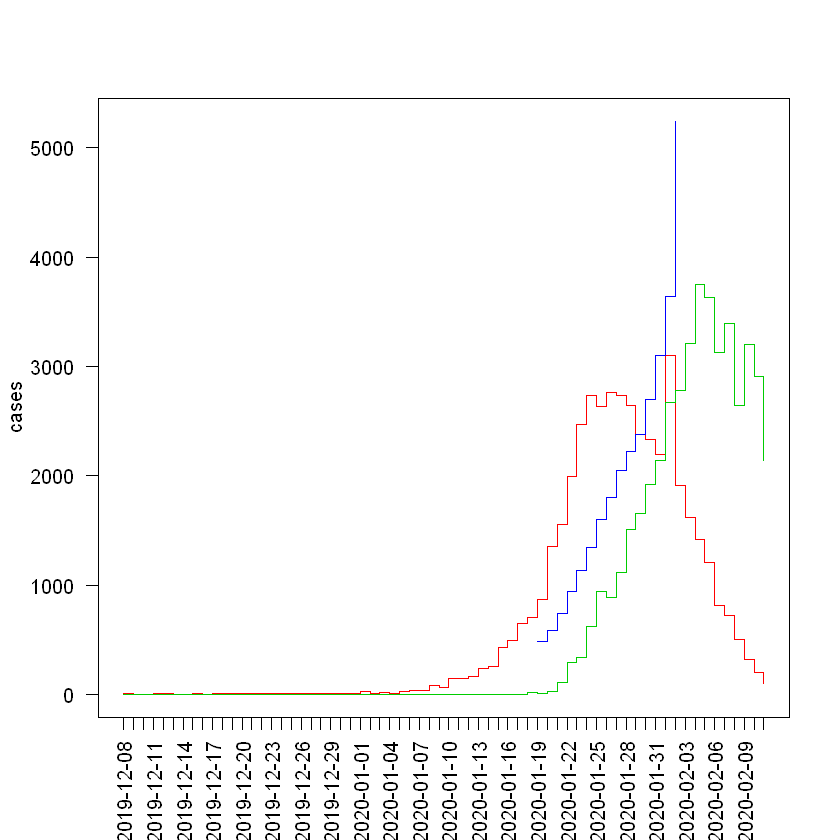

[1] 3


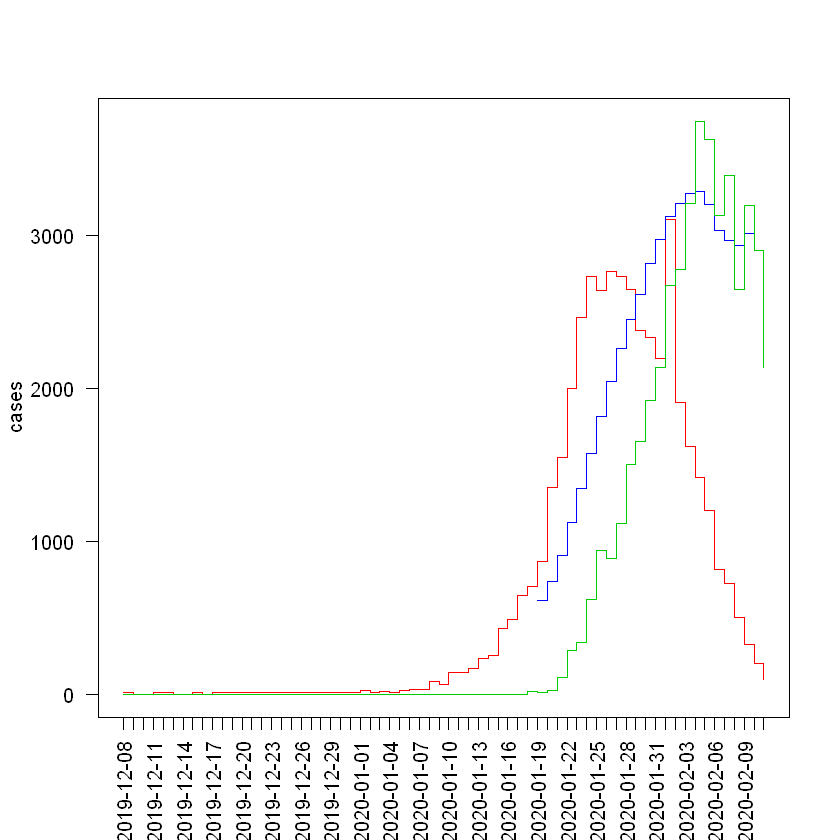

In [8]:
for(x in 1:length(chinanowcast)){
    dates=chinanowcast[[x]][[1]][,"date"]
    matplot(x=dates,y=chinanowcast[[x]][[1]][,c("onset","cases","diagnosis")],type="s",lty=1,las=2,col=c(2,4,3),xlab="",ylab="cases",xaxt="n")
    axis(1,dates,dates,las=2)
    print(x)
}